<a href="https://colab.research.google.com/github/Nyamadie/Dynamic-time-warping/blob/main/DTW_Distances_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/QFHD'

/content/drive/.shortcut-targets-by-id/1zgbI4HtAh4L5VsbEGVeF9fSUylAVhvLx/QFHD


In [ ]:
!pip install tsai dtaidistance

## Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from qf_plus_shared.src.signal_processing import *
from qf_plus_shared.src.data_quality import *
sys.path.append('')
from qf_plus_develop.qfhd.src.data_utils import get_subject_id
from qf_plus_shared.src.global_vars import *
from qf_plus_development.src.utilities import get_meta_data
import xgboost as xgb

# Data

In [ ]:
meta_data_file = get_meta_data('')

In [ ]:
pickle_file_path = ""
with open(pickle_file_path, 'rb') as file:
    signal_data = pickle.load(file)


In [ ]:
meta_data_file

,Use_4_Train,Clinic,Subject_ID,Age,IsMale,Hx_HTN,HxCVD,DM,HxSmoke,HxStroke,HxCOPD,Strain,LVEF
1,False,BHRT,BHRT RH1 12.29.21,76.625000,False,False,True,False,True,False,False,NaN,NaN
2,True,BHRT,BHRT MB1 12.29.21,76.733333,True,False,True,True,True,False,False,9.0,45.0
3,False,JFHC,JFHC VC1 12.14.21,57.813889,True,False,True,True,False,False,False,NaN,NaN
4,False,JFHC,JFHC PG1 12.14.21,64.963889,False,False,True,True,False,False,False,NaN,NaN
5,True,JFHC,JFHC SW1 12.14.21,69.366667,True,False,False,True,True,False,True,8.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,False,Mid GA,KT 08.05.20,75.255556,True,False,True,True,False,False,False,NaN,NaN
654,True,Mid GA,RC 08.14.20,63.347222,True,False,True,False,False,False,False,NaN,48.0
655,False,Mid GA,MP 08.05.20,84.650000,False,False,False,False,False,False,False,NaN,65.0
656,False,Mid GA,TK 08.05.20,70.308333,False,False,True,True,False,False,False,NaN,63.0


In [ ]:
pickle_file   = ''

pickle_data = pd.read_pickle(pickle_file)

loaded_data = pickle_data

filenames = list(loaded_data['file_data'])
filenames.sort()

In [ ]:
pickle_data

In [ ]:
filenames[:10]

['AA 05.28.21.1.csv',
 'AA 05.28.21.2.csv',
 'AA 05.28.21.3.csv',
 'AC 02.04.21.1.csv',
 'AC 02.04.21.2.csv',
 'AC 02.04.21.3.csv',
 'AD 06.11.21.1.csv',
 'AD 06.11.21.2.csv',
 'AD 06.11.21.3.csv',
 'AG 03.03.21.1.csv']

In [ ]:
meta_data_file = meta_data_file[(meta_data_file['Use_4_Train']) & (meta_data_file['Strain'].notna())]

In [ ]:
meta_data_file.head()

,Use_4_Train,Clinic,Subject_ID,Age,IsMale,Hx_HTN,HxCVD,DM,HxSmoke,HxStroke,HxCOPD,Strain,LVEF
2,True,BHRT,BHRT MB1 12.29.21,76.733333,True,False,True,True,True,False,False,9.0,45.0
5,True,JFHC,JFHC SW1 12.14.21,69.366667,True,False,False,True,True,False,True,8.0,39.0
6,True,JFHC,JFHC RR1 12.14.21,75.800000,True,False,True,False,True,False,True,17.0,56.0
8,True,JFHC,JFHC JF1 12.14.21,46.463889,True,False,False,False,False,False,False,13.0,43.0
9,True,JFHC,JFHC MD1 12.07.21,62.625000,True,False,False,False,True,False,False,14.0,44.0


In [ ]:
pickle_data['file_data']['CL 02.25.21.2.csv'].columns

## Calculate SNR

In [ ]:
def calculate_snr(signal):
    """Calculate the SNR of a PPG signal using a more accurate method."""
    # Step 1: Filter the signal to isolate the heart rate frequency band
    filtered_signal = bandpass_filter(signal,0.80,2.50)

    # Step 2: Calculate signal power (filtered signal) and noise power (difference)
    signal_power = np.mean(filtered_signal**2)
    noise_power = np.mean((signal - filtered_signal)**2)

    # Step 3: Calculate SNR in dB
    snr = 10 * np.log10(signal_power / noise_power)

    return snr

## Obtain Signal

In [ ]:
def get_signals(subject_id=None, filename=None):
    signals = []

    # Case where subject_id is provided
    if subject_id:
        for file_name in filenames:
            if get_subject_id(file_name) == subject_id:
                signals.append(loaded_data['file_data'][file_name]['cycle_10hz_filt'])  # Append signal of subject_id

        if len(signals) < 1:
            return []  # No matching signals found
        elif len(signals) == 1:
            return signals[0]  # Only one signal found, return it
        else:
            # Multiple signals found, use the specified sort_by criterion to select the best one
            best_signal = None
            best_value = None

            for signal in signals:
                snr_value = calculate_snr(signal)

                # Select the best signal based on the calculated snr value
                if best_value is None or (snr_value > best_value):
                    best_value = snr_value
                    best_signal = signal

            return  best_signal

    # Case where filename is provided
    else:
        return loaded_data['file_data'][filename]['cycle_10hz_filt']

In [ ]:
subject_id = get_subject_id(filenames[0])
signal = get_signals(subject_id=subject_id)
signal.tail()

,cycle_10hz_filt
2776,216.593703
2777,226.348535
2778,235.759033
2779,246.374072
2780,253.085063


## Extract Features

In [ ]:
import pickle
import pandas as pd
import numpy as np
from dtaidistance import dtw
from scipy.stats import skew, kurtosis

pickle_data = signal_data['file_data']

# Initialize storage for DTW features
dtw_features = {}

distinct_subject_ids = meta_data_file['Subject_ID'].astype(str).unique()

def normalize_signal(signal):
    signal_mean = np.mean(signal)
    signal_std = np.std(signal)
    return (signal - signal_mean) / signal_std

for subject_id in distinct_subject_ids:
    subject_signals = [key for key in pickle_data.keys() if subject_id in key]
    if len(subject_signals) == 0:
        print(f"Skipping {subject_id}, no signals found.")
        continue
    elif len(subject_signals) == 1:
        # If only one signal is found, store its information directly
        signal = subject_signals[0]
        cycle_signal = np.array(pickle_data[signal]['cycle'], dtype=np.double)  # Convert to numpy array
        cycle_signal = normalize_signal(cycle_signal)  # Normalize the signal

        dtw_features[subject_id] = {
            'dtw_mean': 0,
            'dtw_max': 0,
            'dtw_min': 0,
            'dtw_variance': 0,
            'dtw_std_dev': 0,
            'dtw_median': 0,
            'dtw_iqr': 0,
            'dtw_skewness': 0,
            'dtw_kurtosis': 0,
            'dtw_range': 0,
            'dtw_25th_percentile': 0,
            'dtw_75th_percentile': 0,
            'dtw_sum': 0,
            'dtw_count_above_threshold': 0,
            'dtw_mad': 0
        }
        print(f"Only one signal found for {subject_id}, storing default DTW values.")
        continue

    # Extract cycle signals for the subject and convert to numpy arrays, then normalize
    subject_cycles = [normalize_signal(np.array(pickle_data[signal]['cycle'], dtype=np.double)) for signal in subject_signals]

    # Calculate DTW distances between all signal pairs using the fast implementation
    dtw_distances = []
    for i in range(len(subject_cycles)):
        for j in range(i + 1, len(subject_cycles)):
            dtw_distance = dtw.distance_fast(subject_cycles[i], subject_cycles[j])
            dtw_distances.append(dtw_distance)

    # Extract DTW features (mean, max, min)
    if dtw_distances:
        dtw_mean = np.mean(dtw_distances)
        dtw_max = np.max(dtw_distances)
        dtw_min = np.min(dtw_distances)
        dtw_variance = np.var(dtw_distances)
        dtw_std_dev = np.std(dtw_distances)
        dtw_median = np.median(dtw_distances)
        dtw_iqr = np.percentile(dtw_distances, 75) - np.percentile(dtw_distances, 25)
        dtw_skewness = skew(dtw_distances)
        dtw_kurtosis = kurtosis(dtw_distances)
        dtw_range = dtw_max - dtw_min
        dtw_25th_percentile = np.percentile(dtw_distances, 25)
        dtw_75th_percentile = np.percentile(dtw_distances, 75)
        dtw_sum = np.sum(dtw_distances)
        dtw_mad = np.mean(np.abs(dtw_distances - dtw_mean)) #Mean Absolute Deviation (MAD)
        dtw_count_above_threshold = sum(d > 1.0 for d in dtw_distances)  # Example threshold of 1.0


        # Store the features in the dictionary
        dtw_features[subject_id] = {
            'dtw_mean': dtw_mean,
            'dtw_max': dtw_max,
            'dtw_min': dtw_min,
            'dtw_variance': dtw_variance,
            'dtw_std_dev': dtw_std_dev,
            'dtw_median': dtw_median,
            'dtw_iqr': dtw_iqr,
            'dtw_skewness': dtw_skewness,
            'dtw_kurtosis': dtw_kurtosis,
            'dtw_range': dtw_range,
            'dtw_25th_percentile': dtw_25th_percentile,
            'dtw_75th_percentile': dtw_75th_percentile,
            'dtw_sum': dtw_sum,
            'dtw_count_above_threshold': dtw_count_above_threshold,
            'dtw_mad': dtw_mad
        }
    else:
        print(f"No DTW distances found for {subject_id}.")

# Optionally convert dtw_features to a DataFrame for better visibility
dtw_features_df = pd.DataFrame.from_dict(dtw_features, orient='index')
print(dtw_features_df)


Only one signal found for NM 06.17.21, storing default DTW values.
Skipping MN 02.26.21, no signals found.
Only one signal found for HL 02.09.21, storing default DTW values.
Skipping SC 12.03.20, no signals found.
Skipping VC 12.03.20, no signals found.
Skipping GG 12.03.20, no signals found.
Skipping VT 12.03.20, no signals found.
Skipping JM 12.03.20, no signals found.
Skipping PW 12.03.20, no signals found.
Skipping YC 12.03.20, no signals found.
Skipping EG 12.03.20, no signals found.
Skipping BS 12.03.20, no signals found.
Skipping AL2 11.19.20, no signals found.
Skipping TV 11.19.20, no signals found.
Skipping CC 11.19.20, no signals found.
Skipping JY 11.19.20, no signals found.
Skipping CB 11.19.20, no signals found.
Skipping JO 11.19.20, no signals found.
Skipping JR 11.19.20, no signals found.
Skipping SX 11.19.20, no signals found.
Skipping JF 11.12.20, no signals found.
Skipping TL 11.12.20, no signals found.
Skipping CV 11.12.20, no signals found.
Skipping YL 11.12.20, no 

In [ ]:
# Convert dtw_features to a DataFrame, making sure the Subject ID is a column and not the index
dtw_features_df = pd.DataFrame.from_dict(dtw_features, orient='index').reset_index()

# Rename the columns to include all the new statistical features for clarity
dtw_features_df.columns = [
    'Subject_ID',
    'dtw_mean',
    'dtw_max',
    'dtw_min',
    'dtw_variance',
    'dtw_std_dev',
    'dtw_median',
    'dtw_iqr',
    'dtw_skewness',
    'dtw_kurtosis',
    'dtw_range',
    'dtw_25th_percentile',
    'dtw_75th_percentile',
    'dtw_sum',
    'dtw_count_above_threshold',
    'dtw_mad'
]

# Merge with the metadata DataFrame on 'Subject_ID'
features_df = dtw_features_df.merge(meta_data_file, on='Subject_ID')

# Display the first few rows of the merged DataFrame
features_df.head()


,Subject_ID,dtw_mean,dtw_max,dtw_min,dtw_variance,dtw_std_dev,dtw_median,dtw_iqr,dtw_skewness,dtw_kurtosis,dtw_range,dtw_25th_percentile,dtw_75th_percentile,dtw_sum,dtw_count_above_threshold,dtw_mad,Use_4_Train,Clinic,Age,IsMale,Hx_HTN,HxCVD,DM,HxSmoke,HxStroke,HxCOPD,Strain,LVEF
0,BHRT MB1 12.29.21,8.792257,10.294502,7.473020,1.343539,1.159111,8.609250,1.410741,0.232893,-1.5,2.821481,8.041135,9.451876,26.376772,3,1.001496,True,BHRT,76.733333,True,False,True,True,True,False,False,9.0,45.0
1,JFHC SW1 12.14.21,14.202120,15.384894,12.396663,1.682121,1.296966,14.824803,1.494116,-0.609495,-1.5,2.988231,13.610733,15.104848,42.606359,3,1.203638,True,JFHC,69.366667,True,False,False,True,True,False,True,8.0,39.0
2,JFHC RR1 12.14.21,12.714182,14.915995,10.438251,3.344445,1.828782,12.788299,2.238872,-0.060726,-1.5,4.477744,11.613275,13.852147,38.142545,3,1.517287,True,JFHC,75.800000,True,False,True,False,True,False,True,17.0,56.0
3,JFHC JF1 12.14.21,12.258194,14.397471,9.105985,5.179655,2.275885,13.271128,2.645743,-0.579444,-1.5,5.291486,11.188556,13.834299,36.774583,3,2.101473,True,JFHC,46.463889,True,False,False,False,False,False,False,13.0,43.0
4,JFHC MD1 12.07.21,16.630816,21.453778,11.090459,18.157057,4.261110,17.348212,5.181659,-0.247766,-1.5,10.363319,14.219336,19.400995,49.892449,3,3.693571,True,JFHC,62.625000,True,False,False,False,True,False,False,14.0,44.0


In [ ]:
print("Columns in features_df:", features_df.columns.tolist())

Columns in features_df: ['Subject_ID', 'dtw_mean', 'dtw_max', 'dtw_min', 'dtw_variance', 'dtw_std_dev', 'dtw_median', 'dtw_iqr', 'dtw_skewness', 'dtw_kurtosis', 'dtw_range', 'dtw_25th_percentile', 'dtw_75th_percentile', 'dtw_sum', 'dtw_count_above_threshold', 'dtw_mad', 'Use_4_Train', 'Clinic', 'Age', 'IsMale', 'Hx_HTN', 'HxCVD', 'DM', 'HxSmoke', 'HxStroke', 'HxCOPD', 'Strain', 'LVEF']


In [ ]:
# Drop unnecessary columns
features_df = features_df.drop(columns=['Use_4_Train', 'Clinic'])

# Columns to encode
columns_to_encode = ['IsMale', 'Hx_HTN', 'HxCVD', 'DM', 'HxSmoke', 'HxStroke', 'HxCOPD']

# Encode boolean values directly
for column in columns_to_encode:
    features_df[column] = features_df[column].astype(int)

# Extract target variable
target = features_df['Strain']

# Drop columns that are not features
features_df = features_df.drop(columns=['Subject_ID', 'Strain', 'LVEF'])

# Show the first few rows of the processed DataFrame
features_df.head()

,dtw_mean,dtw_max,dtw_min,dtw_variance,dtw_std_dev,dtw_median,dtw_iqr,dtw_skewness,dtw_kurtosis,dtw_range,dtw_25th_percentile,dtw_75th_percentile,dtw_sum,dtw_count_above_threshold,dtw_mad,Age,IsMale,Hx_HTN,HxCVD,DM,HxSmoke,HxStroke,HxCOPD
0,8.792257,10.294502,7.473020,1.343539,1.159111,8.609250,1.410741,0.232893,-1.5,2.821481,8.041135,9.451876,26.376772,3,1.001496,76.733333,1,0,1,1,1,0,0
1,14.202120,15.384894,12.396663,1.682121,1.296966,14.824803,1.494116,-0.609495,-1.5,2.988231,13.610733,15.104848,42.606359,3,1.203638,69.366667,1,0,0,1,1,0,1
2,12.714182,14.915995,10.438251,3.344445,1.828782,12.788299,2.238872,-0.060726,-1.5,4.477744,11.613275,13.852147,38.142545,3,1.517287,75.800000,1,0,1,0,1,0,1
3,12.258194,14.397471,9.105985,5.179655,2.275885,13.271128,2.645743,-0.579444,-1.5,5.291486,11.188556,13.834299,36.774583,3,2.101473,46.463889,1,0,0,0,0,0,0
4,16.630816,21.453778,11.090459,18.157057,4.261110,17.348212,5.181659,-0.247766,-1.5,10.363319,14.219336,19.400995,49.892449,3,3.693571,62.625000,1,0,0,0,1,0,0


In [ ]:
# Prepare feature matrix (X) and target variable (y)
X = features_df
y = target

# Split the data into training and remaining data (80% training, 20% remaining)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=42)

# Split the remaining data into testing and validation sets (50% testing, 50% validation of the remaining 20%)
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.03, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=15,  # Number of parameter settings that are sampled
    scoring='neg_mean_absolute_error',  # Objective function
    cv=3,  # Number of cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the random search
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best MAE: {-random_search.best_score_}")

# Train the model with the best parameters on the full training data
best_params = random_search.best_params_
model = XGBRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters found: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.8}
Best MAE: 2.865994554354646


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

MAE for predictions on training dataset 1.4438986829809242
MAE for predictions on testing dataset 3.2136182527284363
MAE for predictions on validation dataset 2.930001785880641


(1.9, 26.1, 7.3088526535034175, 21.27116443634033)

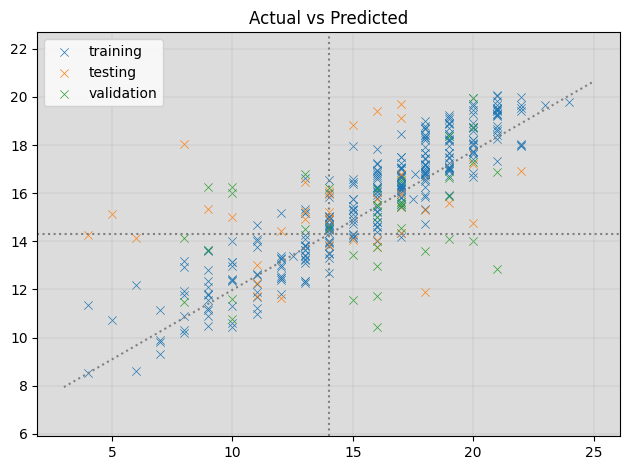

In [ ]:
y_pred = model.predict(X_train)
plt.scatter(y_train, y_pred, marker='x', linewidths=.5, label="training")
mae = mean_absolute_error(y_pred, y_train)
print(f"MAE for predictions on training dataset {mae}" )

y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, marker='x', linewidths=.5, label="testing")
mae = mean_absolute_error(y_pred , y_test)
print(f"MAE for predictions on testing dataset {mae}")

y_pred = model.predict(X_val)
plt.scatter(y_val, y_pred, marker='x', linewidths=.5, label="validation")
mae = mean_absolute_error(y_pred , y_val)
print(f"MAE for predictions on validation dataset {mae}")

plt.title("Actual vs Predicted")

# Get axis limits for line placement
min_value = min(y_pred) - 1
max_value = max(y_pred) + 1
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
# Define line positions

v_line_x = (x_max + x_min) / 2  # Middle of x-axis
h_line_y = (y_max + y_min) / 2  # Middle of y-axis

diagonal_start = (x_min, y_min)  # Lower left corner
diagonal_end = (x_max, y_max)  # Upper right corner

# Plot vertical line
plt.axvline(x=v_line_x, color='gray', linestyle='dotted')#, label='Vertical Line')

# Plot horizontal line
plt.axhline(y=h_line_y, color='gray', linestyle='dotted')#, label='Horizontal Line')

# plt.plot([min_value, max_value], [min_value, max_value], linestyle=':', color='gray')  # Diagonal line
# Plot diagonal line
plt.plot([diagonal_start[0], diagonal_end[0]], [diagonal_start[1], diagonal_end[1]],
         color='gray', linestyle='dotted')#, label='Diagonal Line')

# Set background color
plt.gca().set_facecolor('#DCDCDC')
plt.tight_layout()
plt.grid(visible='minor', linewidth=.25)
plt.legend()
plt.axis('equal')

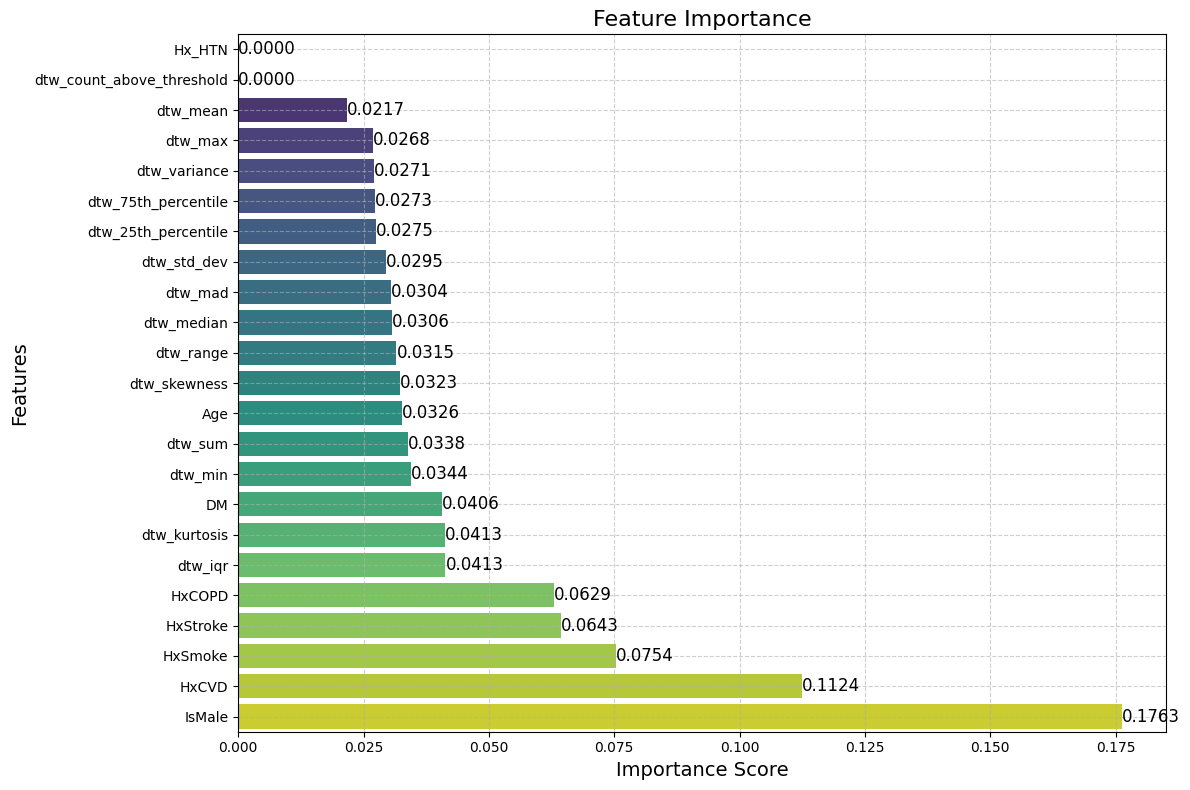

In [ ]:
# Get feature importances from XGBoost model
feature_importances = model.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(feature_importances)

# Create a sorted list of feature names
sorted_features = np.array(X_train.columns)[sorted_indices]

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances[sorted_indices], y=sorted_features, palette="viridis")

# Add title and labels
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate the bars with importance values outside the bars
for index, value in enumerate(feature_importances[sorted_indices]):
    plt.text(value, index, f'{value:.4f}', va='center', ha='left', color='black', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()